In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, TracePredictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from palmerpenguins import load_penguins
plt.style.use('ggplot')

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chapter 3

In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [5]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [6]:
#  prior predictive --> mu and sigma
samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (146). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf65165220>]],
      dtype=object)

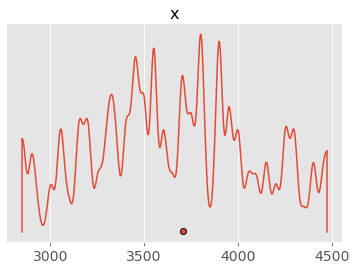

In [7]:
az.plot_density(data=samples['mass'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf6552edf0>]],
      dtype=object)

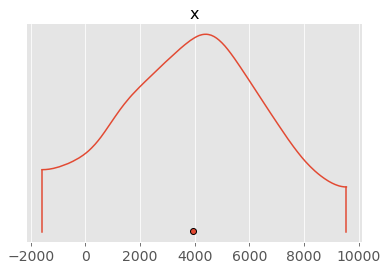

In [8]:
az.plot_density(data=samples['mu'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf658a78e0>]],
      dtype=object)

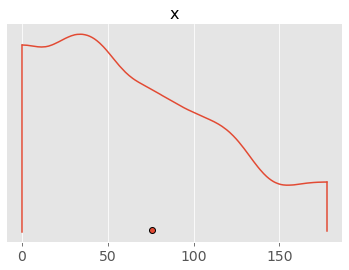

In [9]:
az.plot_density(data=samples['sigma'].numpy())

In [10]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [11]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

Sample: 100%|██████████| 3000/3000 [00:32, 91.74it/s, step size=9.59e-01, acc. prob=0.899] 


In [12]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3705.62     35.62   3705.54   3650.91   3767.55   2175.95      1.00
     sigma    435.08     22.60    433.64    397.27    471.62   1736.56      1.00

Number of divergences: 0


In [13]:
samples_1 = mcmc.get_samples()

In [14]:
samples_1

{'mu': tensor([3708.6552, 3701.5059, 3754.3045,  ..., 3742.4060, 3667.2568,
         3742.3905], dtype=torch.float64),
 'sigma': tensor([459.8884, 453.5906, 427.3002,  ..., 451.5343, 415.8204, 437.9186],
        dtype=torch.float64)}

## 3.2.1 Linear Penguins

In [68]:
adelie_flipper_length = torch.from_numpy(penguins.loc[adelie_mask, 'flipper_length_mm'].values)
adelie_mass = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

In [69]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

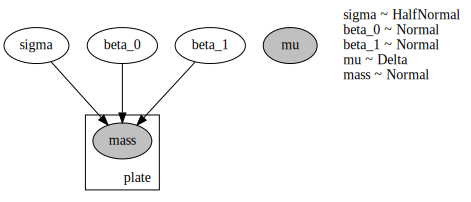

In [70]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, adelie_mass),
    render_distributions=True
    )

### MCMC

- `mcmc` = fitted MCMC object
- `mcmc_samples` = only the latent variables are returned via the `.get_samples()` method
    - `mu` is not returned in the `mcmc.get_samples()` dict
    - deterministic parts are only available via the `Predictive` function. Similarily, observed samples is only available via this function too 

In [71]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    
    return site_stats

In [72]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc_simple = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_simple.run(flipper_length=adelie_flipper_length, mass=adelie_mass)

Sample: 100%|██████████| 800/800 [01:55,  6.90it/s, step size=3.21e-02, acc. prob=0.929]


In [73]:
mcmc_simple.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0  -2403.02    918.48  -2364.43  -4186.48  -1073.09    129.88      1.02
    beta_1     32.14      4.83     31.91     25.23     41.48    129.35      1.02
     sigma    388.30     22.37    387.20    351.10    424.92    178.84      1.01

Number of divergences: 0


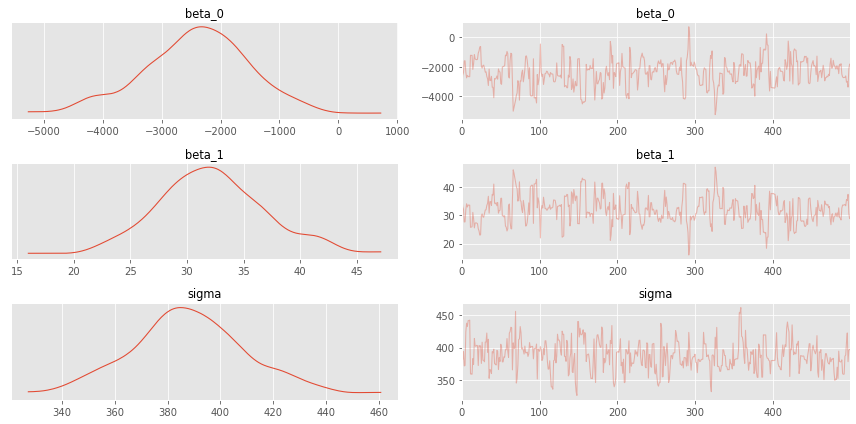

In [74]:
# trace plots are interesting for only only chain
az.plot_trace(az.from_pyro(mcmc_simple))
plt.tight_layout()

#### Posterior Predictive Distribution

Sample mass and mu from posterior. 

In [22]:
# latent variables
mcmc_samples = mcmc_simple.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# latent variables: 
predictive_samples = predictive(flipper_length=adelie_flipper_length, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

mass: (1000, 146)
mu: (1000, 1, 146)


In [24]:
def mcmc_fit(predictive):
    mass = predictive['mass']
    mass_mu = mass.mean(axis=0)
    mass_std = mass.std(axis=0)

    mass_df = pd.DataFrame({
        'feat': adelie_flipper_length,
        'mean': mass_mu,
        'high': mass_mu + mass_std,
        'low': mass_mu - mass_std}
    )

    return mass_df.sort_values(by=['feat'])

In [25]:
mass_df = mcmc_fit(predictive=predictive_samples)

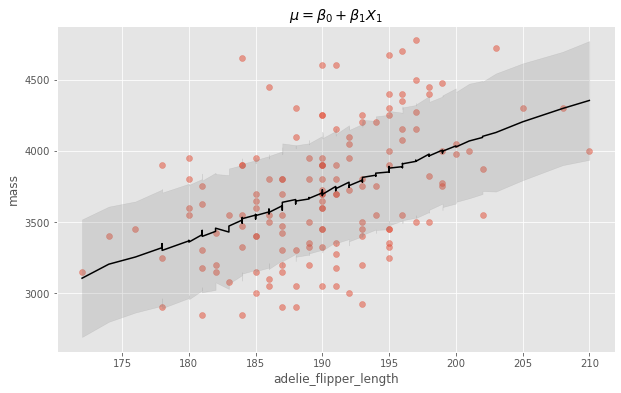

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), adelie_mass.numpy(), alpha=0.5)
plt.plot(mass_df['feat'], mass_df['mean'], color='black')
plt.fill_between(
    mass_df['feat'], mass_df['high'], mass_df['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

### Stochastic Variational Inference (SVI)

Using SVI for a simple linear regression like this is probably overkill, but lets do it anyways.

For the surrogate, we use the predefined `AutoNormal`

**NOT WORKING: I believe it has to do with the autoguide. Solution could be to implement the guide by hand**

In [27]:
def linear_model(flipper_length, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 4000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 4000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

In [28]:
def guide(flipper_length, mass=None):

    sigma_loc = pyro.param(
        'sigma_loc', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_0_loc = pyro.param(
        'beta_0_loc', lambda: torch.tensor(0.))
    beta_0_scale = pyro.param(
        'beta_0_scale', lambda: torch.tensor(1.), constraint=constraints.positive)

    beta_1_loc = pyro.param('beta_1_loc', lambda: torch.randn(1))
    beta_1_scale = pyro.param(
        'beta_1_scale', lambda: torch.ones(1), constraint=constraints.positive)
    

    sigma = pyro.sample('sigma', dist.HalfNormal(sigma_loc, torch.tensor(0.05)))
    beta_0 = pyro.sample('beta_0', dist.Normal(beta_0_loc, beta_0_scale))
    beta_1 = pyro.sample('beta_1', dist.Normal(beta_1_loc, beta_1_scale))

    return {'beta_0': beta_0, 'beta_1': beta_1, 'sigma': sigma}

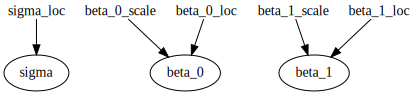

In [29]:
pyro.render_model(
    guide, 
    model_args=(adelie_flipper_length, adelie_mass_obs), 
    render_params=True
    )

In [30]:
custom_guide = guide(linear_model)
custom_guide

{'beta_0': tensor(0.2135, grad_fn=<AddBackward0>),
 'beta_1': tensor([-0.4723], grad_fn=<AddBackward0>),
 'sigma': tensor(0.1708, grad_fn=<AbsBackward0>)}

In [31]:
auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
auto_guide

AutoNormal()

In [ ]:
pyro.clear_param_store()

# These should be reset each training loop
#auto_guide = pyro.infer.autoguide.AutoNormal(linear_model)
adam = pyro.optim.Adam({'lr': 0.005})
elbo = pyro.infer.Trace_ELBO()
svi = SVI(linear_model, custom_guide, adam, elbo)

losses = []
for step in range(2001): 
    loss = svi.step(adelie_flipper_length, adelie_mass)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

pyro.get_param_store() is comprised of learned parameters that will be used in the `Predictive` stage. Instead of providing samples, the `guide` parameter is used to construct the posterior predictive distribution

In [ ]:
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

In [ ]:
auto_guide.quantiles([0.25, 0.5, 0.75])

In [ ]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
        
    return site_stats

In [ ]:
predictive = Predictive(linear_model, guide=auto_guide, num_samples=1000)
svi_samples = predictive(adelie_flipper_length, mass=None)
svi_mass = svi_samples['mass']

In [ ]:
mcmc_fit(predictive=svi_samples)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(adelie_flipper_length.numpy(), np.exp(adelie_mass.numpy()), alpha=0.5)
#plt.plot(adelie_flipper_length.numpy(), svi_mass.mean(axis=0))
plt.title('$\mu =  \\beta_0 + \\beta_1X_1$')
plt.show()

## 3.3 Multiple Linear Regression

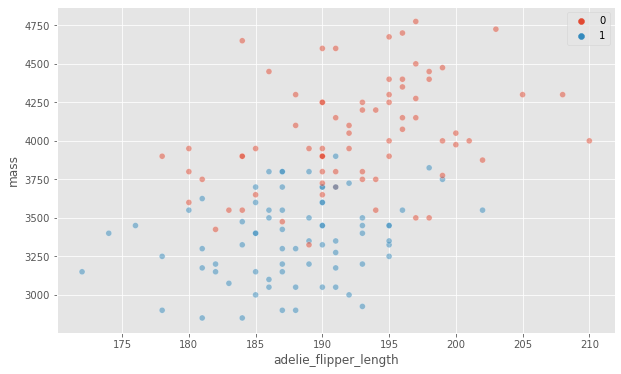

In [215]:
sex_obs = torch.from_numpy(penguins.loc[adelie_mask, 'sex'].replace({'male': 0, 'female': 1}).values)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.show()

In [216]:
def linear_model(flipper_length, sex, mass=None):

    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 3000.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 3000.))
    beta_2 = pyro.sample('beta_2', dist.Normal(0., 3000.))
    mu = pyro.deterministic('mu', beta_0 + beta_1 * flipper_length + beta_2 * sex)

    with pyro.plate('plate'):   
        preds = pyro.sample('mass', dist.Normal(mu, sigma), obs=mass)  

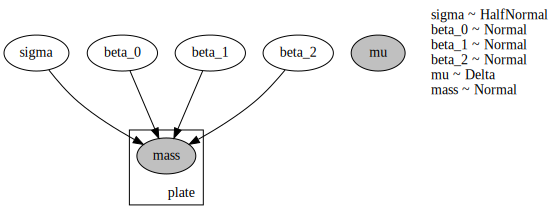

In [217]:
pyro.render_model(
    linear_model, 
    model_args=(adelie_flipper_length, sex_obs, adelie_mass),
    render_distributions=True
    )

In [218]:
kernel = NUTS(linear_model, adapt_step_size=True)
mcmc = MCMC(kernel, num_samples=500, warmup_steps=300, num_chains=1)
mcmc.run(flipper_length=adelie_flipper_length, sex=sex_obs, mass=adelie_mass)

Sample: 100%|██████████| 800/800 [03:10,  4.20it/s, step size=2.55e-02, acc. prob=0.928]


In [219]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    817.22    772.83    850.25   -480.71   1934.87    186.52      1.00
    beta_1     16.77      4.01     16.67     11.10     23.59    187.21      1.00
    beta_2   -595.72     54.07   -594.58   -672.03   -494.18    297.18      1.00
     sigma    289.38     17.26    288.38    263.50    319.66    312.12      1.00

Number of divergences: 0


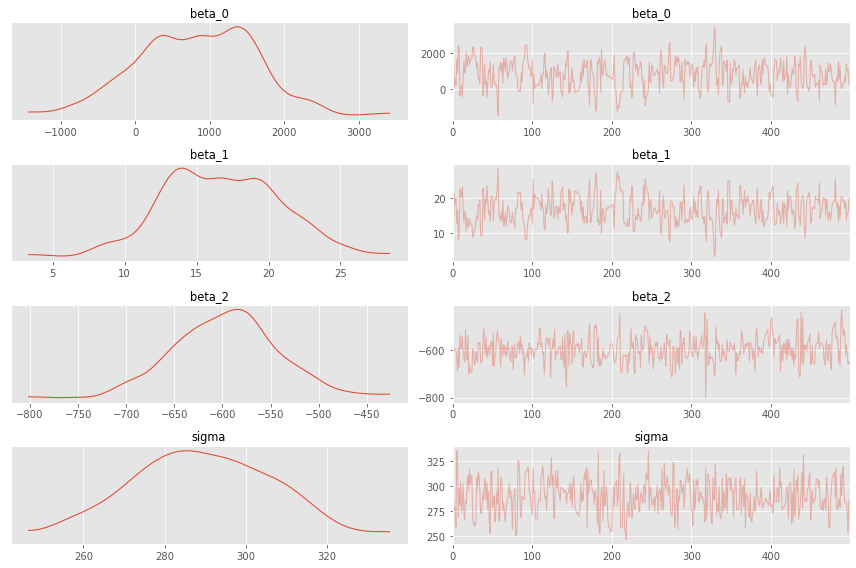

In [220]:
az.plot_trace(az.from_pyro(mcmc))
plt.tight_layout()

In [221]:
# latent variables
mcmc_samples = mcmc.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(linear_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(flipper_length=adelie_flipper_length, sex=sex_obs, mass=None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

mass: (1000, 146)
mu: (1000, 1, 146)


In [222]:
mass_mu = predictive_samples['mass'].numpy().mean(axis=0)
mass_std = predictive_samples['mass'].numpy().std(axis=0)

predictions = pd.DataFrame({
    'sex': sex_obs,
    'flipper': adelie_flipper_length,
    'mass_mu': mass_mu,
    'mass_std': mass_std,
    'high': mass_mu + mass_std,
    'low': mass_mu - mass_std
})

predictions = predictions.sort_values(by=['flipper'])

In [60]:
male = predictions[predictions['sex'] == 0]
female = predictions[predictions['sex'] == 1]

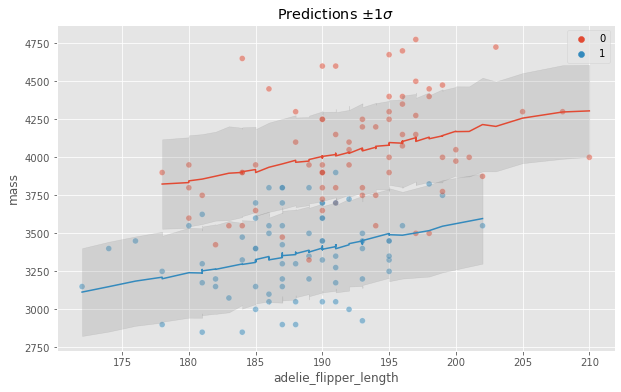

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=adelie_flipper_length, y=adelie_mass_obs, hue=sex_obs, alpha=0.5)
plt.plot(male['flipper'], male['mass_mu'])
plt.plot(female['flipper'], female['mass_mu'])
plt.fill_between(
    male['flipper'], male['high'], male['low'], alpha=0.2, color='grey')
plt.fill_between(
    female['flipper'], female['high'], female['low'], alpha=0.2, color='grey')
plt.xlabel('adelie_flipper_length')
plt.ylabel('mass')
plt.title('Predictions $\pm 1 \sigma$ ')
plt.show()

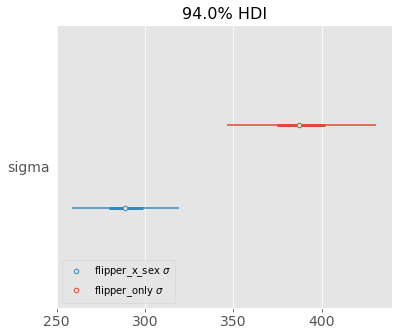

In [88]:
mcmc_multiple_az = az.from_pyro(mcmc)
mcmc_simple_az = az.from_pyro(mcmc_simple)

az.plot_forest([mcmc_simple_az, mcmc_multiple_az], var_names=['sigma'])
# manually specify to avoid confusion
plt.legend(['flipper_x_sex $\sigma$', 'flipper_only $\sigma$'])
plt.show()

### Counterfactuals

## Generalized Linear Models

### Logistic Regression

In [226]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
bill_length_obs = torch.from_numpy(penguins.loc[species_filter, 'bill_length_mm'].values)
species = pd.Categorical(penguins.loc[species_filter, 'species'])
species_codes = torch.from_numpy(species.codes).to(torch.float64)

In [227]:
def logistic_model(bill_length, species=None):

    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.))
    mu = beta_0 + torch.mul(beta_1, bill_length) ## support broadcasting to common shape
    theta = pyro.deterministic('theta', torch.sigmoid(mu))
    db = pyro.deterministic('db', -beta_0 / beta_1)

    with pyro.plate('plate'):
        y1 = pyro.sample('y1', dist.Bernoulli(theta), obs=species)

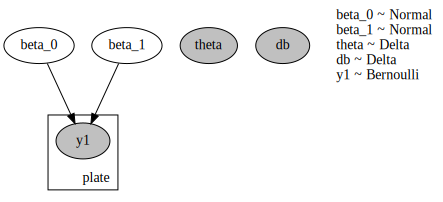

In [228]:
# we don't observe theta or db
pyro.render_model(
    logistic_model, 
    model_args=(bill_length_obs, species_codes),
    render_distributions=True)

In [229]:
kernel = NUTS(logistic_model, adapt_step_size=True)
mcmc_logistic = MCMC(kernel, num_samples=500, warmup_steps=300)
mcmc_logistic.run(bill_length=bill_length_obs, species=species_codes)

Sample: 100%|██████████| 800/800 [00:43, 18.33it/s, step size=5.67e-02, acc. prob=0.923]


In [230]:
mcmc_logistic.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0    -34.93      4.01    -34.85    -41.89    -28.68     87.32      1.02
    beta_1      0.79      0.09      0.79      0.64      0.94     86.72      1.02

Number of divergences: 0


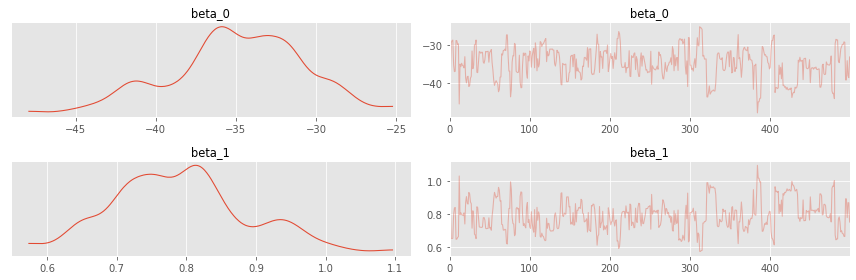

In [231]:
az.plot_trace(az.from_pyro(mcmc_logistic))
plt.tight_layout()

In [232]:
# latent variables
mcmc_samples = mcmc_logistic.get_samples(num_samples=1000)
# posterior samples 
predictive = Predictive(logistic_model, mcmc_samples)
# posterior predictive
predictive_samples = predictive(bill_length_obs, None) 

for k, v in predictive_samples.items():
    print(f'{k}: {tuple(v.shape)}')

y1: (1000, 214)
theta: (1000, 1, 214)
db: (1000, 1)


In [263]:
prob_mu = predictive_samples['theta'].numpy().mean(axis=0).flatten()
prob_std = predictive_samples['theta'].numpy().std(axis=0).flatten()
db_mu = predictive_samples['db'].numpy().mean()
db_std = predictive_samples['db'].numpy().std()

predictions = pd.DataFrame({
    'bill_length': bill_length_obs,
    'prob_mu': prob_mu,
    'prob_std': prob_std,
    'high': prob_mu + prob_std,
    'low': prob_mu - prob_std
})

predictions = predictions.sort_values(by=['bill_length'])

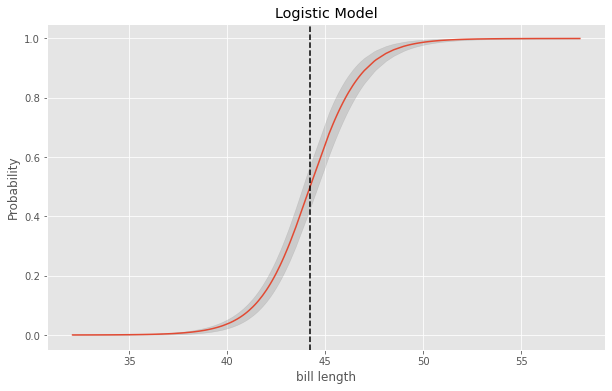

In [277]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=predictions['bill_length'], y=predictions['prob_mu'])
plt.fill_between(
    predictions['bill_length'], predictions['high'], predictions['low'],
    alpha=0.25, color='grey')
plt.axvline(
    x=predictive_samples['db'].numpy().mean(), linestyle='--', color='black')
plt.xlabel('bill length')
plt.ylabel('Probability')
plt.title('Logistic Model')
plt.show()